In [ ]:
pip install holidays-es

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install skforecast 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


#Set-Up


In [ ]:
# Importing necessary librarie
#===============================================================================
import os
import json
import warnings
import urllib
import urllib.request
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import holidays_es
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from dateutil.parser import parse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from math import sqrt
from datetime import timedelta, datetime
from holidays_es import Province

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline


In [ ]:

#PATH TONY
COLAB = ('COLAB_GPU' in os.environ)  # True if we are in a Colab environment

if COLAB:
    DIRNAME = '/content/drive/My Drive/Antonio/ALEMANIA/MASTERS/GISMA/Master_Thesis/Code/DATA/'
else:
    DIRNAME = './'
if COLAB:
    # Mount drive
    from google.colab import drive
    import shutil
    
    drive.mount("/content/drive")

print('Ready!!')

print(os.listdir(DIRNAME))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ready!!
['aemet.csv']


In [ ]:
'''
#PATH EGE
COLAB = ('COLAB_GPU' in os.environ)  # True if we are in a Colab environment

if COLAB:
    DIRNAME = '/content/drive/My Drive/Colab Notebooks/Master_Thesis/'
    
else:
    DIRNAME = './'
if COLAB:
    # Mount drive
    from google.colab import drive
    import shutil
    
    drive.mount("/content/drive")

print('Ready!!')

print(os.listdir(DIRNAME))
'''

'\n#PATH EGE\nCOLAB = (\'COLAB_GPU\' in os.environ)  # True if we are in a Colab environment\n\nif COLAB:\n    DIRNAME = \'/content/drive/My Drive/Colab Notebooks/Master_Thesis/\'\n    \nelse:\n    DIRNAME = \'./\'\nif COLAB:\n    # Mount drive\n    from google.colab import drive\n    import shutil\n    \n    drive.mount("/content/drive")\n\nprint(\'Ready!!\')\n\nprint(os.listdir(DIRNAME))\n'

##API


In [ ]:
#ESIOS API to get the energy consumption data
class PandasDataBase:
    """
    This class saves the downloaded data locally and expends it incrementally upon download calls from esios
    """
    def __init__(self):
        print()


class ESIOS(object):
    
    def __init__(self, token):
        """
        Class constructor
        :param token: string given by the SIOS to you when asked to: Consultas Sios <consultasios@ree.es>
        """
        # The token is unique: You should ask for yours to: Consultas Sios <consultasios@ree.es>
        if token is None:
            print('The token is unique: You should ask for yours to: Consultas Sios <consultasios@ree.es>')
        self.token = token

        self.allowed_geo_id = [3, 8741]  # España y Peninsula
        
        # standard format of a date for a query        
        self.dateformat = '%Y-%m-%dT%H:%M:%S'
        
        # dictionary of available series
        
        self.__offer_indicators_list = list()
        self.__analysis_indicators_list = list()
        self.__indicators_name__ = dict()
        self.available_series = dict()

        print('Getting the indicators...')
        self.available_series = self.get_indicators()

    def __get_headers__(self):
        """
        Prepares the CURL headers
        :return:
        """
        # Prepare the arguments of the call
        headers = dict()
        headers['Accept'] = 'application/json; application/vnd.esios-api-v1+json'
        headers['Content-Type'] = 'application/json'
        headers['Host'] = 'api.esios.ree.es'
        headers['Authorization'] = 'Token token=\"' + self.token + '\"'
        headers['Cookie'] = ''
        return headers
        
    def get_indicators(self):
        """
        Get the indicators and their name.
        The indicators are the indices assigned to the available data series
        :return:
        """
        fname = 'indicators.pickle'
        import os
        if os.path.exists(fname):
            # read the existing indicators file
            with open(fname, "rb") as input_file:
                all_indicators, self.__indicators_name__, self.__offer_indicators_list, self.__analysis_indicators_list = pickle.load(input_file)
        else:
            # create the indicators file querying the info to ESIOS
            """
            curl "https://api.esios.ree.es/offer_indicators" -X GET
            -H "Accept: application/json; application/vnd.esios-api-v1+json"
            -H "Content-Type: application/json"
            -H "Host: api.esios.ree.es"
            -H "Authorization: Token token=\"5c7f9ca844f598ab7b86bffcad08803f78e9fc5bf3036eef33b5888877a04e38\""
            -H "Cookie: "
            """
            all_indicators = dict()
            self.__indicators_name__ = dict()

            # This is how the URL is built
            url = 'https://api.esios.ree.es/offer_indicators'

            # Perform the call
            req = urllib.request.Request(url, headers=self.__get_headers__())
            with urllib.request.urlopen(req) as response:
                try:
                    json_data = response.read().decode('utf-8')
                except:
                    json_data = response.readall().decode('utf-8')

                result = json.loads(json_data)

            # fill the dictionary
            indicators = dict()
            self.__offer_indicators_list = list()
            for entry in result['indicators']:
                name = entry['name']
                id_ = entry['id']
                indicators[name] = id_
                self.__indicators_name__[id_] = name
                self.__offer_indicators_list.append([name, id_])

            all_indicators[u'indicadores de curvas de oferta'] = indicators

            """
            curl "https://api.esios.ree.es/indicators" -X GET
            -H "Accept: application/json; application/vnd.esios-api-v1+json"
            -H "Content-Type: application/json" -H "Host: api.esios.ree.es"
            -H "Authorization: Token token=\"5c7f9ca844f598ab7b86bffcad08803f78e9fc5bf3036eef33b5888877a04e38\""
            -H "Cookie: "
            """
            url = 'https://api.esios.ree.es/indicators'

            req = urllib.request.Request(url, headers=self.__get_headers__())
            with urllib.request.urlopen(req) as response:
                try:
                    json_data = response.read().decode('utf-8')
                except:
                    json_data = response.readall().decode('utf-8')
                result = json.loads(json_data)

            # continue filling the dictionary
            indicators = dict()
            self.__analysis_indicators_list = list()
            for entry in result['indicators']:
                name = entry['name']
                id_ = entry['id']
                indicators[name] = id_
                self.__indicators_name__[id_] = name
                self.__analysis_indicators_list.append([name, id_])

            all_indicators[u'indicadores de análisis '] = indicators

            # save the indictators
            with open(fname, "wb") as output_file:
                dta = [all_indicators, self.__indicators_name__, self.__offer_indicators_list, self.__analysis_indicators_list]
                pickle.dump(dta, output_file)
        
        return all_indicators
        
    def get_names(self, indicators_list):
        """
        Get a list of names of the given indicator indices
        :param indicators_list:
        :return:
        """
        names = list()
        for i in indicators_list:
            names.append(self.__indicators_name__[i])
        
        return np.array(names, dtype=np.object)
        
    def save_indicators_table(self, fname='indicadores.xlsx'):
        """
        Saves the list of indicators in an excel file for easy consultation
        :param fname:
        :return:
        """
        data = self.__offer_indicators_list + self.__analysis_indicators_list
        
        df = pd.DataFrame(data=data, columns=['Nombre', 'Indicador'])
        
        df.to_excel(fname)

    def __get_query_json__(self, indicator, start_str, end_str):
        """
        Get a JSON series
        :param indicator: series indicator
        :param start: Start date
        :param end: End date
        :return:
        """
        # This is how the URL is built

        #  https://www.esios.ree.es/es/analisis/1293?vis=2&start_date=21-06-2016T00%3A00&end_date=21-06-2016T23%3A50&compare_start_date=20-06-2016T00%3A00&groupby=minutes10&compare_indicators=545,544#JSON
        url = 'https://api.esios.ree.es/indicators/' + indicator + '?start_date=' + start_str + '&end_date=' + end_str

        # Perform the call
        req = urllib.request.Request(url, headers=self.__get_headers__())
        with urllib.request.urlopen(req) as response:
            try:
                json_data = response.read().decode('utf-8')
            except:
                json_data = response.readall().decode('utf-8')
            result = json.loads(json_data)
            
        return result

    def get_data(self, indicator, start, end):
        """
        :param indicator: Series indicator
        :param start: Start date
        :param end: End date
        :return:
        """
        # check types: Pass to string for the url
        if type(start) is dt.datetime:
            start_str = start.strftime(self.dateformat)
        else:
            start_str = start
        
        if type(end) is dt.datetime:
            end_str = end.strftime(self.dateformat)
        else:
            end_str = end
        
        if type(indicator) is int:
            indicator = str(indicator)
            
        # get the JSON data
        result = self.__get_query_json__(indicator, start_str, end_str)

        # transform the data
        d = result['indicator']['values']  # dictionary of values
        
        if len(d) > 0:
            hdr = list(d[0].keys())  # headers    
            data = np.empty((len(d), len(hdr)), dtype=np.object)
            
            for i in range(len(d)):  # iterate the data entries
                for j in range(len(hdr)):  # iterate the headers
                    h = hdr[j]
                    val = d[i][h]
                    data[i, j] = val
                    
            df = pd.DataFrame(data=data, columns=hdr)  # make the DataFrame
            
            df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])  # convert to datetime
            
            df = df.set_index('datetime_utc')  # Set the index column
            
            # del df.index.name  # to avoid the index name bullshit
            
            return df
        else:
            return None
    
    def get_multiple_series(self, indicators, start, end):
        """
        Get multiple series data
        :param indicators: List of indicators
        :param start: Start date
        :param end: End date
        :return:
        """

        df_list = list()
        names = list()
        for indicator in indicators:

            name = self.__indicators_name__[indicator]
            names.append(name)

            print('Parsing ' + name)

            # download the series in a DataFrame
            df_new = self.get_data(indicator, start, end)

            if df_new is not None:
                # the default name for the series is 'value' we must change it
                df_new.rename(columns={'value': name}, inplace=True)

                # save
                file_handler = open(str(indicator) + ".pkl", "wb")
                pickle.dump(df_new, file_handler)
                file_handler.close()

            df_list.append(df_new)

        return df_list, names

    def merge_series(self, df_list, names, pandas_sampling_interval='1H'):
        """
        Merge a list of separately downloaded DataFrames into a single one
        :param df_list: List of ESIOS downloaded DataFrames
        :param names: list with the names of the main series of each DataFrame
        :param pandas_sampling_interval: Pandas interval for resampling (1 hour as default)
        :return: Merged DataFrame
        """

        merged_df = None
        print('merging')
        for df, name in zip(df_list, names):
            # print(name)

            if df is not None:

                if name == 'Precio mercado SPOT Diario':
                    df = df[df.geo_id == 3]  # pick spain only

                dfp = df[[name]].astype(float)  # .resample(pandas_sampling_interval).pad()
                # dfp2 = pd.DataFrame(data=dfp.values, index=dfp.index, columns=[name])
                if merged_df is None:
                    merged_df = dfp
                else:
                    merged_df = merged_df.join(dfp)
            else:
                print(name, ': The dataFrame is None')

        return merged_df


#Data


In [ ]:
#Taking Energy data from their API
#===============================================================================
token = 'ec949d63388ee9e0f1c5ab4755e5ac5bf91a0ca8fff434179ab40a5ce640c4fc'

esios = ESIOS(token)

indicators_ = [1347, 1357]
start_ = '2018-01-01' #DateStart
end_ = '2022-01-01' #DateEnd

df_list, names = esios.get_multiple_series(indicators_, start_, end_)
df_energy = esios.merge_series(df_list, names, pandas_sampling_interval='15M')
df_energy #variable with the energy information

In [ ]:
#Reading weather Dataset
#===============================================================================
FILENAME = 'aemet.csv'
df_weather = pd.read_csv(DIRNAME + FILENAME) #path to access weather dataset
print(df_weather.head())

In [ ]:
#Renaming columns to english
#===============================================================================
df_weather = df_weather.rename(columns={"fecha": "date", "horatmin": "hourtmin", "horatmax": "hourtmax", "velmedia": "avgspe", "racha": "streak", 
                                        "horaracha": "hourstreak", "sol": "sun", "horaPresMax": "hourPresMax", "horaPresMin": "hourPresMin"})

In [ ]:
#Drop columns with no information
#===============================================================================
df_weather = df_weather.drop(["indicativo", "nombre", "provincia"], axis=1)

In [ ]:
#Wherever it's not defined, we set 4:00 as minimum temperature hour
# and 14:00 as maximum temperature hour
#===============================================================================
df_weather['hourtmin'] = df_weather['hourtmin'].replace('Varias', '04:00')
df_weather['hourtmax'] = df_weather['hourtmax'].replace('Varias', '14:00')

In [ ]:
#Adding date to the hour values
#===============================================================================
df_weather['hourtmin'] = pd.to_datetime(df_weather['date'].apply(str) + ' ' + df_weather['hourtmin'].apply(str))
df_weather['hourtmax'] = pd.to_datetime(df_weather['date'].apply(str) + ' ' + df_weather['hourtmax'].apply(str))

In [ ]:
#Cast to datetime the following columns
#===============================================================================
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['hourtmin'] = pd.to_datetime(df_weather['hourtmin'], errors ='coerce')
df_weather['hourtmax'] = pd.to_datetime(df_weather['hourtmax'], errors ='coerce')

In [ ]:
#Rounding hour values to match with the energy consumption data
df_weather['hourtminround'] = df_weather['hourtmin'].dt.round('H')
df_weather['hourtmaxround'] = df_weather['hourtmax'].dt.round('H')
df_weather = df_weather.drop(["hourtmin", "hourtmax"], axis=1)

In [ ]:
#We set date as index & resample every 1 hour
#===============================================================================
df_weather = df_weather.set_index('date')
df_weather = df_weather.resample('1H').ffill()

In [ ]:
#Changing the format inside the columns
#===============================================================================
df_weather['tmed'] = df_weather['tmed'].str.replace(',','.').astype(float)
df_weather['prec'] = df_weather['prec'].str.replace(',','.').astype(float)
df_weather['avgspe'] = df_weather['avgspe'].str.replace(',','.').astype(float)
df_weather['streak'] = df_weather['streak'].str.replace(',','.').astype(float)
df_weather['sun'] = df_weather['sun'].str.replace(',','.').astype(float)
df_weather['presMax'] = df_weather['presMax'].str.replace(',','.').astype(float)
df_weather['presMin'] = df_weather['presMin'].str.replace(',','.').astype(float)

In [ ]:
#Creating a new column to assign maximum and minimum temperature values to the
#given hour
indx = df_weather.index
indx
df_weather['auxiliar'] = indx
df_weather['auxiliardate'] = indx.date
df_weather['temperature1'] = np.zeros
df_weather.dtypes

for i in range(len(df_weather)): 
    if df_weather["auxiliar"][i] == df_weather['hourtminround'][i]: 
         df_weather['temperature1'][i] = float(df_weather['tmin'][i].replace(',', '.'))
    elif df_weather["auxiliar"][i] == df_weather['hourtmaxround'][i]:
        df_weather['temperature1'][i] = float(df_weather['tmax'][i].replace(',', '.'))
    else: 
        df_weather['temperature1'][i] = np.nan

In [ ]:
#Dropping columns with extracted information
df_weather = df_weather.drop(["hourtminround", "hourtmaxround", "tmin", "tmax",], axis=1)

In [ ]:
#Making the temperature1 column float
df_weather['temperature1'] = df_weather['temperature1'].astype(float)
df_weather.info

In [ ]:
#Assigning first value to temperature and replacing NaN values
#with linear interpolation and saving the information in a new column
df_weather['temperature1'][0] = df_weather['temperature1'].dropna()[2]
df_weather['temperature1'][-1] = 15.2
df_weather['temperature'] = df_weather['temperature1'].interpolate(method ='linear', order = 3, limit_direction = 'both')

In [ ]:
#Dropping dummy column
df_weather = df_weather.drop(['temperature1',], axis=1)

In [ ]:
#Similar process in Temperature applied for Pressure.
df_weather['hourPresMax'] = df_weather['hourPresMax'].replace('Varias', np.nan)
df_weather['hourPresMin'] = df_weather['hourPresMin'].replace('Varias', np.nan)
df_weather['hourPresMin'][0] = 15
df_weather = df_weather.fillna(method='ffill')

In [ ]:
#Matching data syntax with our auxiliar column for comparison
df_weather['auxiliarstr'] = np.zeros
for i in range(len(df_weather)):
  df_weather['hourPresMax'][i] = df_weather['auxiliardate'][i].strftime("%Y/%m/%d") + ' ' + df_weather['hourPresMax'][i] + ':00:00'
  df_weather['hourPresMin'][i] = df_weather['auxiliardate'][i].strftime("%Y/%m/%d") + ' ' +str( df_weather['hourPresMin'][i]) + ':00:00'
  df_weather['auxiliarstr'][i] = str(df_weather['auxiliar'][i].strftime("%Y/%m/%d %H:%M:%S"))
  df_weather['auxiliarstr'][i] = str(df_weather['auxiliar'][i].strftime("%Y/%m/%d %H:%M:%S"))

In [ ]:
#Creating a dummy column to assign pressure values for each hour
df_weather['pressure1'] = np.zeros
for i in range(len(df_weather)): 
    if df_weather["auxiliarstr"][i] == df_weather['hourPresMax'][i]: 
         df_weather['pressure1'][i] = float(df_weather['presMax'][i])
    elif df_weather["auxiliarstr"][i] == df_weather['hourPresMin'][i]:
        df_weather['pressure1'][i] = float(df_weather['presMin'][i])
    else: 
        df_weather['pressure1'][i] = np.nan

In [ ]:
#Making pressure1 column float
df_weather['pressure1'] = df_weather['pressure1'].apply(lambda x: float(x))

In [ ]:
#Assigning the first value for interpolation
df_weather['pressure1'][0] = 1024.3
df_weather['pressure'] = df_weather['pressure1'].interpolate(method ='linear', order = 3, limit_direction = 'both')

In [ ]:
#Creating holiday array (zeros)
#===============================================================================
df_weather['holiday'] = 0

#Holiday information from holiday_es API
#===============================================================================
holidays2018 = Province(name="ceuta", year=2018).holidays()
print(holidays2018)
holidays2019 = Province(name="ceuta", year=2019).holidays()
print(holidays2019)
holidays2020 = Province(name="ceuta", year=2020).holidays()
print(holidays2020)
holidays2021 = Province(name="ceuta", year=2021).holidays() 
print(holidays2021)

{'national_holidays': [datetime.date(2018, 1, 1), datetime.date(2018, 1, 6), datetime.date(2018, 3, 30), datetime.date(2018, 5, 1), datetime.date(2018, 8, 15), datetime.date(2018, 10, 12), datetime.date(2018, 11, 1), datetime.date(2018, 12, 6), datetime.date(2018, 12, 8), datetime.date(2018, 12, 25)], 'regional_holidays': [datetime.date(2018, 3, 29)], 'local_holidays': [datetime.date(2018, 6, 13), datetime.date(2018, 8, 6)]}
{'national_holidays': [datetime.date(2019, 1, 1), datetime.date(2019, 4, 19), datetime.date(2019, 5, 1), datetime.date(2019, 8, 15), datetime.date(2019, 10, 12), datetime.date(2019, 11, 1), datetime.date(2019, 12, 6), datetime.date(2019, 12, 25)], 'regional_holidays': [datetime.date(2019, 1, 7), datetime.date(2019, 4, 18)], 'local_holidays': [datetime.date(2019, 6, 13), datetime.date(2019, 8, 5), datetime.date(2019, 8, 12), datetime.date(2019, 9, 2)]}
{'national_holidays': [datetime.date(2020, 1, 1), datetime.date(2020, 1, 6), datetime.date(2020, 4, 10), datetime.d

In [ ]:
#To make it match and extract the information, we change the format manually
#===============================================================================
holidays_spain = [p.split(')')[0] for p in str(holidays2018).split('(') if ')' in p] + [p.split(')')[0] for p in str(holidays2019).split('(') if ')' in p] + [p.split(')')[0] for p in str(holidays2020).split('(') if ')' in p] + [p.split(')')[0] for p in str(holidays2021).split('(') if ')' in p]

l_replace = [s.replace(', ', '-') for s in holidays_spain]
l_replace = [s.replace('-1-', '-01-') for s in l_replace]
l_replace = [s.replace('-2-', '-02-') for s in l_replace]
l_replace = [s.replace('-3-', '-03-') for s in l_replace]
l_replace = [s.replace('-4-', '-04-') for s in l_replace]
l_replace = [s.replace('-5-', '-05-') for s in l_replace]
l_replace = [s.replace('-6-', '-06-') for s in l_replace]
l_replace = [s.replace('-7-', '-07-') for s in l_replace]
l_replace = [s.replace('-8-', '-08-') for s in l_replace]
l_replace = [s.replace('-9-', '-09-') for s in l_replace]
l_replace = [s.replace('2018-01-1', '2018-01-01') for s in l_replace]
l_replace = [s.replace('2018-01-6', '2018-01-06') for s in l_replace]
l_replace = [s.replace('2018-05-1', '2018-05-01') for s in l_replace]
l_replace = [s.replace('2018-11-1', '2018-11-01') for s in l_replace]
l_replace = [s.replace('2018-12-6', '2018-12-06') for s in l_replace]
l_replace = [s.replace('2018-12-8', '2018-12-08') for s in l_replace]
l_replace = [s.replace('2018-08-6', '2018-01-06') for s in l_replace]
l_replace = [s.replace('2019-01-1', '2019-01-01') for s in l_replace]
l_replace = [s.replace('2019-01-7', '2019-01-07') for s in l_replace]
l_replace = [s.replace('2019-11-6', '2019-11-06') for s in l_replace]
l_replace = [s.replace('2019-05-1', '2019-05-01') for s in l_replace]
l_replace = [s.replace('2019-12-6', '2019-12-06') for s in l_replace]
l_replace = [s.replace('2019-11-1', '2019-11-01') for s in l_replace]
l_replace = [s.replace('2019-08-5', '2019-08-05') for s in l_replace]
l_replace = [s.replace('2019-09-2', '2019-09-02') for s in l_replace]
l_replace = [s.replace('2020-01-1', '2020-01-01') for s in l_replace]
l_replace = [s.replace('2020-01-6', '2020-01-06') for s in l_replace]
l_replace = [s.replace('2020-05-1', '2020-05-01') for s in l_replace]
l_replace = [s.replace('2020-04-9', '2020-04-09') for s in l_replace]
l_replace = [s.replace('2020-12-8', '2020-12-08') for s in l_replace]
l_replace = [s.replace('2020-09-2', '2020-09-02') for s in l_replace]
l_replace = [s.replace('2020-12-7', '2020-12-07') for s in l_replace]
l_replace = [s.replace('2020-08-5', '2020-08-05') for s in l_replace]
l_replace = [s.replace('2021-01-1', '2021-01-01') for s in l_replace]
l_replace = [s.replace('2021-01-6', '2021-01-06') for s in l_replace]
l_replace = [s.replace('2021-04-2', '2021-04-02') for s in l_replace]
l_replace = [s.replace('2021-11-1', '2021-11-01') for s in l_replace]
l_replace = [s.replace('2021-12-6', '2021-12-06') for s in l_replace]
l_replace = [s.replace('2021-12-8', '2021-12-08') for s in l_replace]
l_replace = [s.replace('2021-04-1', '2021-04-01') for s in l_replace]

l_replace = [s.replace('2021-05-1', '2021-05-01') for s in l_replace]
l_replace = [s.replace('2021-08-5', '2021-08-05') for s in l_replace]
l_replace = [s.replace('2021-09-2', '2021-09-02') for s in l_replace]



print(l_replace)

['2018-01-01', '2018-01-06', '2018-03-30', '2018-05-01', '2018-08-15', '2018-10-12', '2018-11-01', '2018-12-06', '2018-12-08', '2018-12-25', '2018-03-29', '2018-06-13', '2018-01-06', '2019-01-01', '2019-04-19', '2019-05-01', '2019-08-15', '2019-10-12', '2019-11-01', '2019-12-06', '2019-12-25', '2019-01-07', '2019-04-18', '2019-06-13', '2019-08-05', '2019-08-12', '2019-09-02', '2020-01-01', '2020-01-06', '2020-04-10', '2020-05-01', '2020-08-15', '2020-10-12', '2020-12-08', '2020-12-25', '2020-04-09', '2020-07-31', '2020-09-02', '2020-12-07', '2020-06-13', '2020-08-05', '2021-01-01', '2021-01-06', '2021-04-02', '2021-10-12', '2021-11-01', '2021-12-06', '2021-12-08', '2021-12-25', '2021-04-01', '2021-05-01', '2021-06-14', '2021-07-20', '2021-08-05', '2021-09-02']


In [ ]:
#Prepraing variables for being used in the loop
#===============================================================================
lista = df_weather['auxiliardate']
l_replace = pd.to_datetime(l_replace).date
hol_ceuta = pd.Series(l_replace)

In [ ]:
#Loop to identify and mark holidays
#===============================================================================
count = 0
for day in df_weather['auxiliardate']:
    for i in range(len(hol_ceuta)):
        if day == hol_ceuta[i]:
            df_weather['holiday'][count] = 1
    count = count + 1
print(count)

In [ ]:
#Loop to set which day is each row (1 =monday, 2= tuesday,...)
#===============================================================================
df_weather['weekday'] = np.zeros
for i in range(len(df_weather)):
  df_weather['weekday'][i] = df_weather['auxiliardate'][i].weekday()

#Merging Datasets

In [ ]:
#We have some extra rows with wrong information
#Deleting those rows:
#===============================================================================
df_energy = df_energy[(df_energy['Demanda en Ceuta']) == (df_energy['Generación en Ceuta'])]
df_energy.info

<bound method DataFrame.info of                            Demanda en Ceuta  Generación en Ceuta
datetime_utc                                                    
2017-12-31 23:00:00+00:00            21.201               21.201
2018-01-01 00:00:00+00:00            20.557               20.557
2018-01-01 01:00:00+00:00            19.335               19.335
2018-01-01 02:00:00+00:00            18.186               18.186
2018-01-01 03:00:00+00:00            17.366               17.366
...                                     ...                  ...
2021-12-31 19:00:00+00:00            26.351               26.351
2021-12-31 20:00:00+00:00            25.812               25.812
2021-12-31 21:00:00+00:00            22.602               22.602
2021-12-31 22:00:00+00:00            20.772               20.772
2021-12-31 23:00:00+00:00            20.072               20.072

[35065 rows x 2 columns]>

In [ ]:
#Deleting extra day because it is not available in energy dataset
#===============================================================================
df_weather.drop(df_weather.loc['2021-12-31'].index, inplace=True)
df_energy = df_energy[~(df_energy.index > '2021-12-30 22:30:00')]

#Reshapping and merging
#===============================================================================
array = df_energy["Demanda en Ceuta"].values
df_weather['consumptionInCeuta'] = array.reshape(-1, 1)
df_final = df_weather

In [ ]:
#Dropping unnecessary columns
#===============================================================================
df_final = df_final.drop(["presMax", "hourPresMax", "presMin", "hourPresMin", "auxiliar", "auxiliardate", "auxiliarstr", "pressure1", "altitud", "hourstreak"], axis=1)

In [ ]:
df_final.head(10)

,tmed,prec,dir,avgspe,streak,sun,temperature,pressure,holiday,weekday,consumptionInCeuta
date,,,,,,,,,,,
2018-01-01 00:00:00,15.6,0.0,33.0,1.7,7.5,7.6,13.300,1024.3,1,0,21.201
2018-01-01 01:00:00,15.6,0.0,33.0,1.7,7.5,7.6,13.075,1024.3,1,0,20.557
2018-01-01 02:00:00,15.6,0.0,33.0,1.7,7.5,7.6,12.850,1024.3,1,0,19.335
2018-01-01 03:00:00,15.6,0.0,33.0,1.7,7.5,7.6,12.625,1024.3,1,0,18.186
2018-01-01 04:00:00,15.6,0.0,33.0,1.7,7.5,7.6,12.400,1024.3,1,0,17.366
2018-01-01 05:00:00,15.6,0.0,33.0,1.7,7.5,7.6,12.175,1024.3,1,0,16.863
2018-01-01 06:00:00,15.6,0.0,33.0,1.7,7.5,7.6,11.950,1024.3,1,0,16.765
2018-01-01 07:00:00,15.6,0.0,33.0,1.7,7.5,7.6,11.725,1024.3,1,0,16.822
2018-01-01 08:00:00,15.6,0.0,33.0,1.7,7.5,7.6,11.500,1024.3,1,0,15.961


#Data Exploration

In [ ]:
!!pip uninstall matplotlib
!!pip install -U matplotlib

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Collecting matplotlib',
 '  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)',
 'Requirement already satisfied: pyparsing>=2.2.1 in /usr/local/lib/python3.7/dist-packages (from matplotlib) (3.0.9)',
 'Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.7/dist-packages (from matplotlib) (4.37.3)',
 'Requirement already satisfied: numpy>=1.17 in /usr/local/lib/python3.7/dist-packages (from matplotlib) (1.21.6)',
 'Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.7/dist-packages (from matplotlib) (0.11.0)',
 'Requirement already satisfied: pillow>=6.2.0 in /usr/local/lib/python3.7/dist-packages (from matplotlib) (7.1.2)',
 'Requirement already satisfied: python-dateutil>=2.7 in /usr/local/lib/python3.7/dist-packages (from matplotlib) (2.8.2)',
 'Requirement already satisfied: kiwisolver>=1.0.1 in /

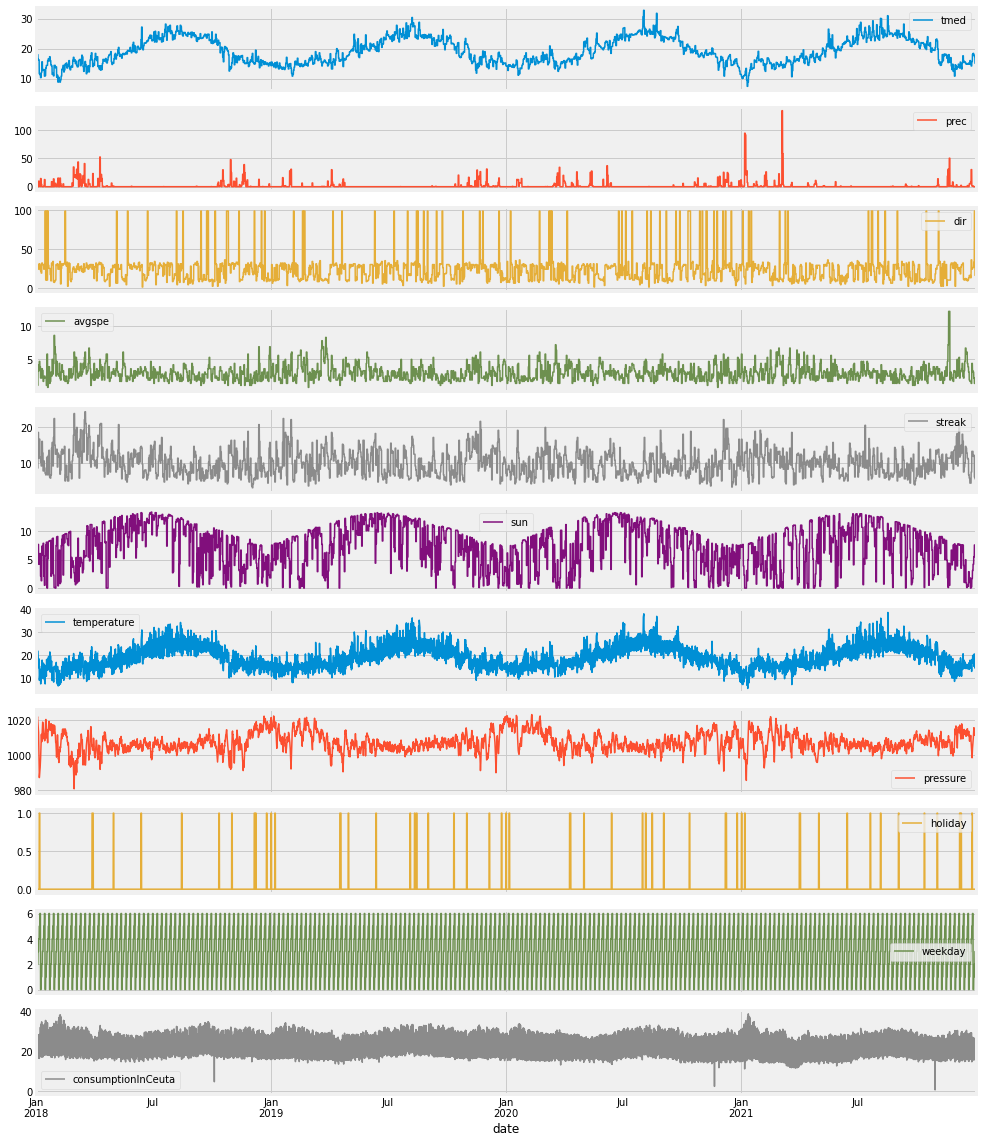

In [ ]:
#Plotting each column of the dataset
axes = df_final.plot.line(
    subplots=True,
    figsize=(15,20)
)

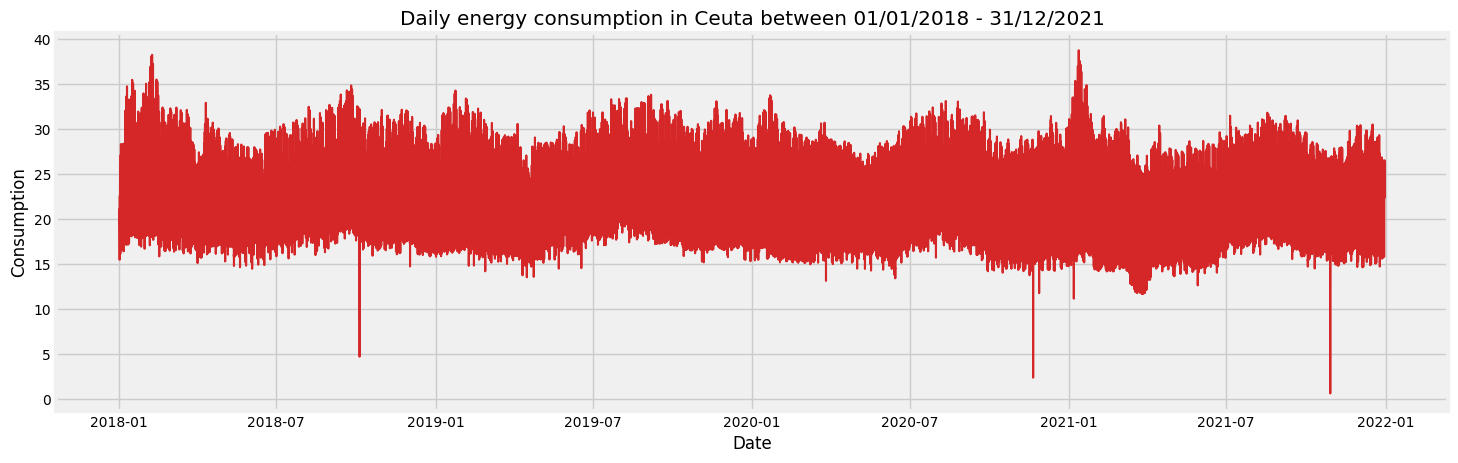

In [ ]:
#Plotting target label
def plot_df(df_final, x, y, title="", xlabel='Date', ylabel='Consumption', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_final, x=df_final.index, y=df_final['consumptionInCeuta'], title='Daily energy consumption in Ceuta between 01/01/2018 - 31/12/2021')    

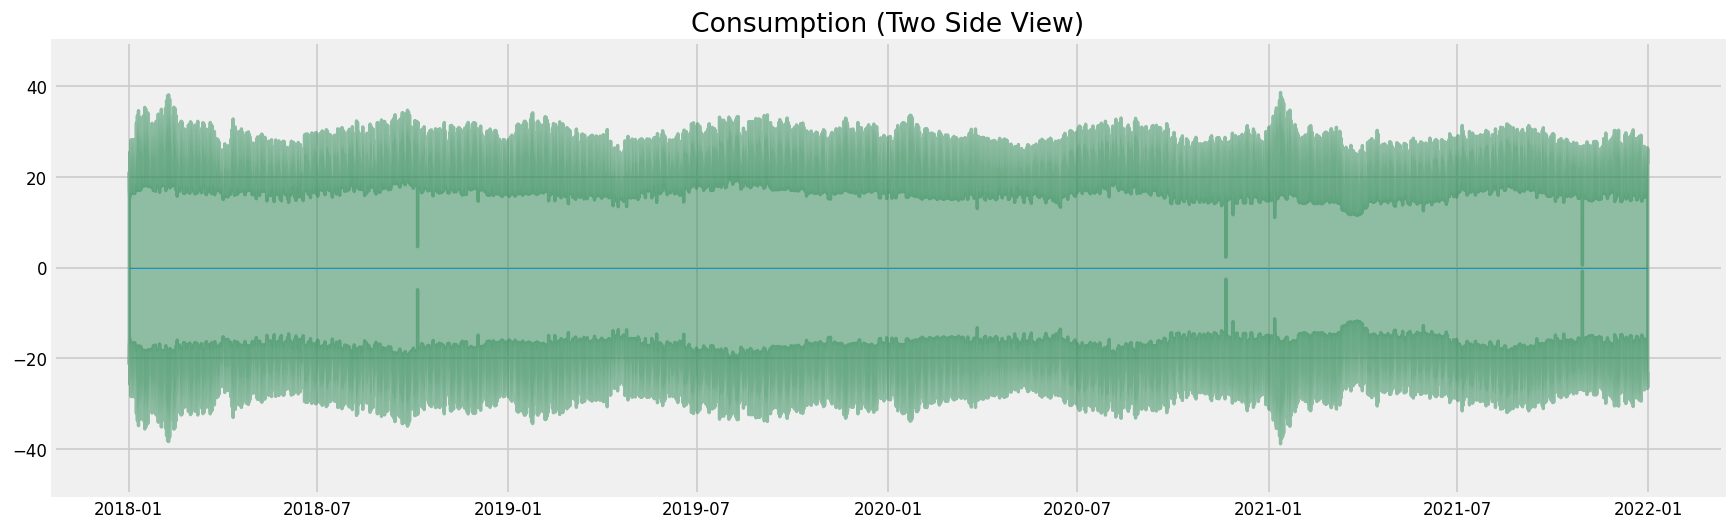

In [ ]:
#Plotting target label with two side view
x = df_final.index.values
y1 = df_final['consumptionInCeuta'].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-50, 50)
plt.title('Consumption (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df_final.index), xmax=np.max(df_final.index), linewidth=.5)
plt.show()

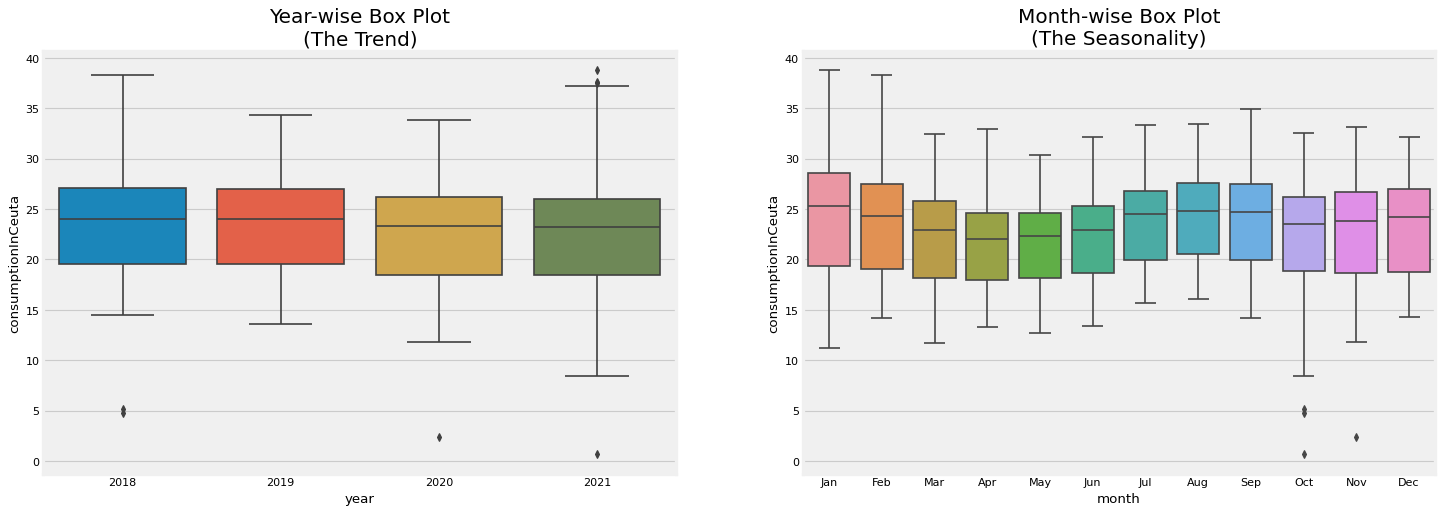

In [ ]:
#Trend and seasonality plots by grouping
df_final['year'] = [d.year for d in df_final.index]
df_final['month'] = [d.strftime('%b') for d in df_final.index]
years = df_final['year'].unique()

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='consumptionInCeuta', data=df_final, ax=axes[0])
sns.boxplot(x='month', y='consumptionInCeuta', data=df_final.loc[~df_final.index.isin([2018, 2021]), :])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

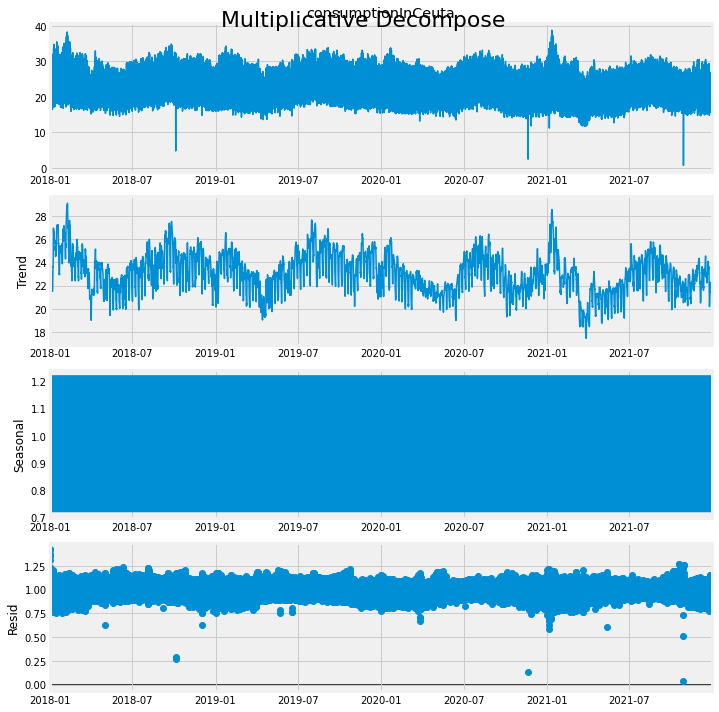

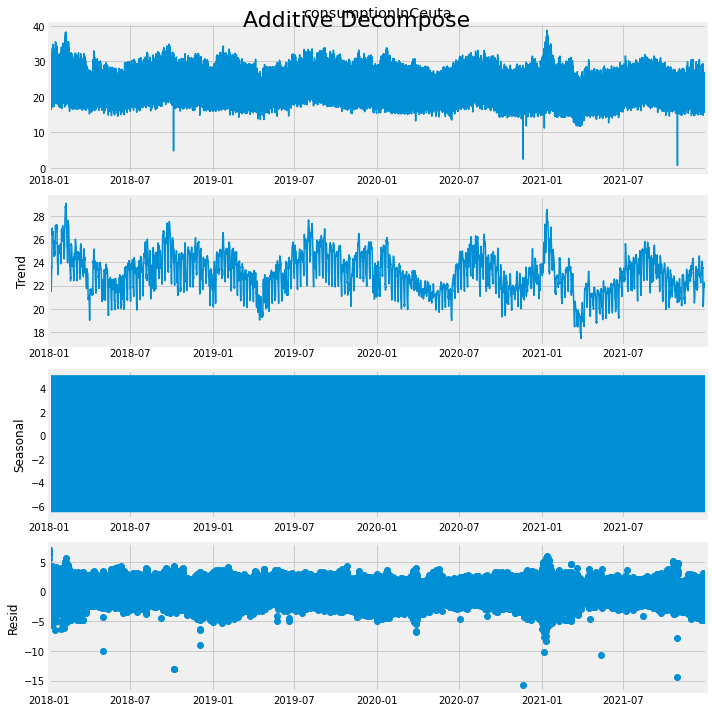

In [ ]:
#Multiplicative and additive seasonal decomposition
result_mul = seasonal_decompose(df_final['consumptionInCeuta'], model='multiplicative', extrapolate_trend='freq')

result_add = seasonal_decompose(df_final['consumptionInCeuta'], model='additive', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
#ADF and KPSS Tests for stationary
result = adfuller(df_final['consumptionInCeuta'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')

result = kpss(df_final['consumptionInCeuta'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'{key}, {value}')

ADF Statistic: -13.488257021961553
p-value: 3.1428826471309925e-25
Critial Values:
1%, -3.430536920280192
Critial Values:
5%, -2.861622614143799
Critial Values:
10%, -2.5668139729124237

KPSS Statistic: 5.749072
p-value: 0.010000
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739


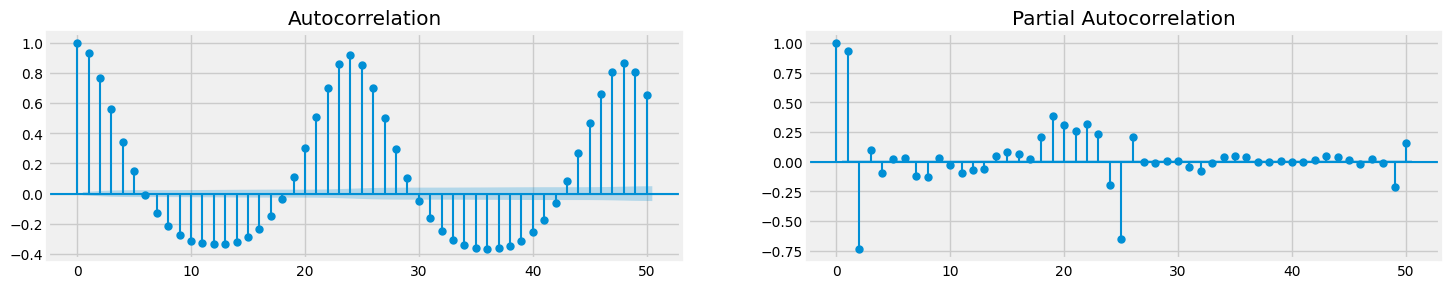

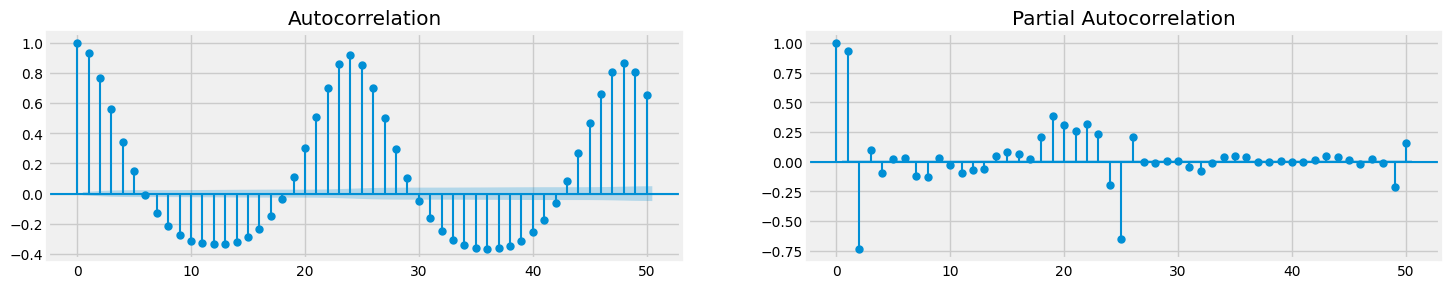

In [ ]:
#Autocorrelation and Partial Autocorrelation graphs
ig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_final['consumptionInCeuta'].tolist(), lags=50, ax=axes[0])
plot_pacf(df_final['consumptionInCeuta'].tolist(), lags=50, ax=axes[1])

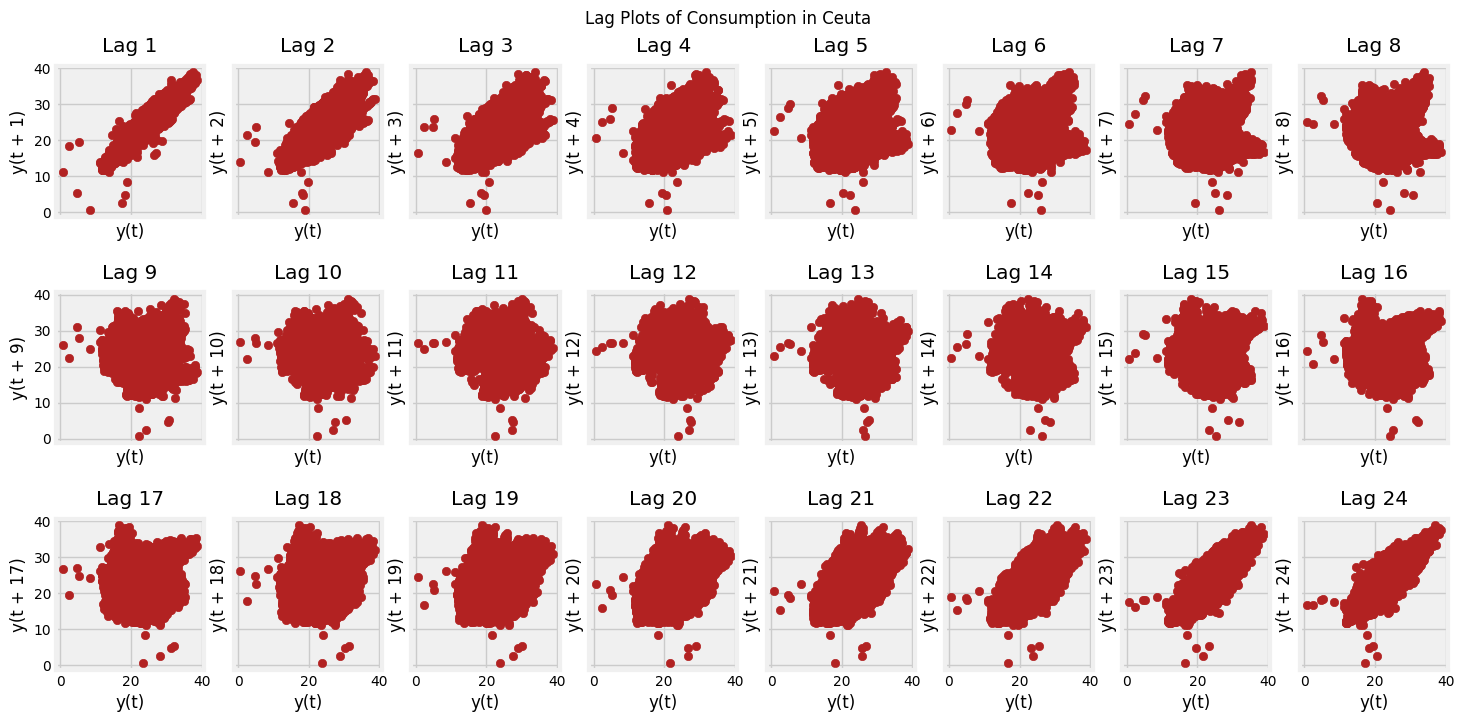

In [ ]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(3, 8, figsize=(16,8), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:24]):
    lag_plot(df_final['consumptionInCeuta'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.subplots_adjust(hspace=0.5)
fig.suptitle('Lag Plots of Consumption in Ceuta', y=0.95)    
plt.show()

In [ ]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid']
df_final = df_final.join(df_reconstructed)

df_final = df_final.fillna(method='ffill').fillna(method='bfill')

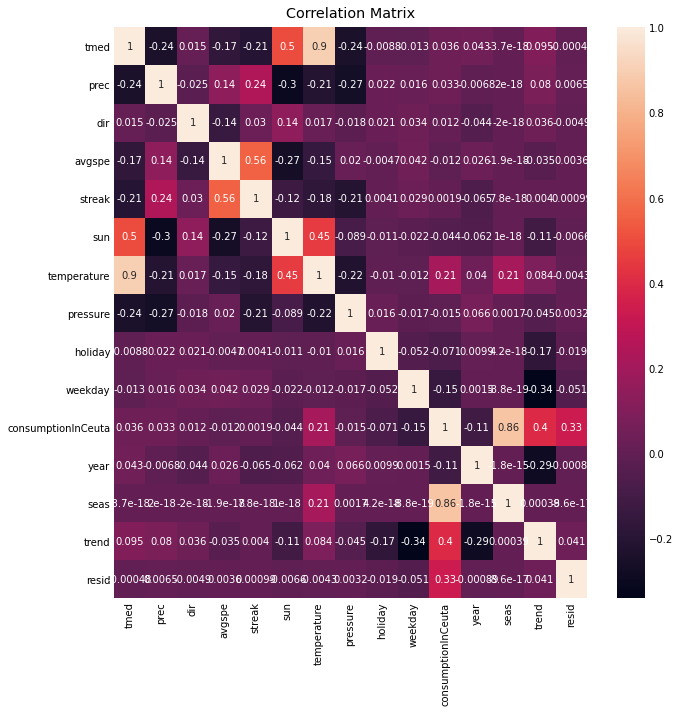

In [ ]:
# Plot heatmap of correlation matrix
sns.heatmap(df_final.corr(), annot=True)
plt.title("Correlation Matrix")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

In [ ]:
#Dropping the columns created for EDA
df_final = df_final.drop(["year", "month",], axis=1)


#Functions


In [ ]:
#Function to set all the required params to compile the model
#===============================================================================
def model_settings(checkPoint_file, opt, model):

    #We save in .h5 the best model found
    #Only the best('save_best_only')  
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    checkPoint_file, save_best_only= True)
    
    #setting optimizer
    #optimizer = tf.keras.optimizers.Adam(lr=opt, amsgrad=True)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=opt, momentum=0.0, rho=0.9,  epsilon=1e-07,  centered=False,   )
                                                
                                              
                                              
                                                
                                       
                                               

    #setting up training:
    #which optimizer?
    #which metric to monitorize?
    #which losses do we calculate?
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics = metric)
    
    return model_checkpoint, model

#Function to make the graphs 
#===============================================================================

def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    
    
    #With this block of code we are visualising each cycle with loses and hits (training and validation)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()
    #The final part of function is to represent RMSE

def show_prediction(plot_data,delta,title):

    labels = ["History", "Real future value", "Model prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]),0))

    if delta:
        future = delta
    else:
         future = 0
    
    plt.title(title)
    
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()

    return

#Test dataset function predicctions
#===============================================================================
def test_predictions(checkPoint_file):

    #We always restore the best available model that was stored in 'checkPoint_file'
    model = tf.keras.models.load_model(checkPoint_file)

    #generating the prediction
    prediction = model.predict(X_test)
    model_prediction = scaler_y.inverse_transform(prediction)

    #Calculate and expose the error
    rmse_mult_model = sqrt(mean_squared_error(y_test_inv, 
                                             model_prediction))
    r2 = r2_score(y_test_inv, model_prediction)

    print('RMSE of the one-hour ahead electricity price, multivariate forecast: {}' .format(round(rmse_mult_model, 3)))
    print('R2 of the one-hour ahead electricity price, multivariate forecast: {}' .format(round(r2, 3)))
    MAE = abs((y_test_inv - model_prediction)).mean()
    print("MAE of the electricity price, multivariate forecast: {}.".format(round(MAE,3)))
    return prediction




#Function for calculating predictions with validation data

num = 1 #With how many validation sets are we going to make predictions? 
step = 0 #What is the step up to the prediction?

def validation_prediction(num,step,model):

    print('We will make predictions for 2 sets of values in the validation set:')

    for x, y in validation.take(num):
        show_prediction(
            [x[23][:, 1].numpy(), y[23].numpy(), model.predict(x)[23]],
            step,
            "Single Step Prediction",
        )
#Definition Disperssion graphs
#===============================================================================

def real_VS_predicted(y_test, prediccion_test):

    print('\n')
    print('\n')
    print('Below is the graph that compares')
    print('the actual value with the predicted value:')

    plt.scatter(y_test, prediccion_test, s=1)
    plt.xlabel("Real: $Y_i$")
    plt.ylabel("Predicted : $\hat{Y}_i$")
    plt.title("real vs predicted: $Y_i$ vs $\hat{Y}_i$")
    plt.show()

#Last graphic, represents some hours and their predictions
#===============================================================================
def graphic_hours(n_hours):
    #31057+23:35064
    t = df_final.index[33057+23:35064]
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 1, 1)
    plt.plot(t[0:n_hours], y_test[0:n_hours], label='Real Data')
    plt.plot(t[0:n_hours], prediccion_T[0:n_hours], label='Test predictions')
    plt.legend()
    plt.title('Actual price and predicted price at the same time')


In [ ]:
#Definition multivariate-data function
#===============================================================================
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = [] # 2 vectors we should give back
    labels = []

    start_index = start_index + history_size #history_size refers to the previous data to take in count
    if end_index is None:
        end_index = len(dataset) - target_size #in case we dont have end-index, we take all the data that fits
        
    for i in range(start_index, end_index - 24 ):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

train_end_idx = 21048 #index to the extent of training data
cv_end_idx = 28056    #index to the extent of validation data
test_end_idx = 35040  #index to the extent of test data

y = df_final['consumptionInCeuta'].values #target column
y = y.reshape(-1, 1) #in column
X = df_final[df_final.columns.drop('consumptionInCeuta')].values  # X is dataset without target

scaler_X = MinMaxScaler(feature_range=(0, 1)) #Scale for X
scaler_y = MinMaxScaler(feature_range=(0, 1)) #Scale for  Y

scaler_X.fit(X[:train_end_idx]) #Adjust scaler for X
scaler_y.fit(y[:train_end_idx]) #Adjust scaler for Y (must be different)

X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

#Principal Component Analysis (we eliminate those with a correlation of more than 85%)
#Mejora levemente la predicción
pca = PCA(n_components=0.85) #Creamos el PCA
pca.fit(X_norm[:train_end_idx]) #Ajustamos el PCA para los datos de entrenamiento

X_pca = pca.transform(X_norm) 

past_history = 192 #each chunk  24
future_target = 24 #just that target
step = 1

dataset_norm = np.concatenate((X_pca, y_norm), axis=1) 
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx - 24, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

batch_size = 32
buffer_size = 1000

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)



#We define common parameters for all the Models we will use.
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError() #Object for error
metric = [tf.keras.metrics.RootMeanSquaredError()] 
#We program the learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))

#This will make the model stop if after 10 iterations is not improving the scores
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

#Re-shape to column
y_test = y_test.reshape(-1, 1)

#Datos de test a la inversa
y_test_inv = scaler_y.inverse_transform(y_test) ##Look for the transformation

#Models


## MLP

In [ ]:
#Cleaning possible variables
#===============================================================================
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(400, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(200, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

checkPoint_file = 'multivariate_mlp.h5'
opt = 6e-3
n_hours = 168

model_checkpoint, multivariate_mlp = model_settings(checkPoint_file,opt, multivariate_mlp)


history = multivariate_mlp.fit(train, epochs=100,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

#Using the functions that we already prepared
#===============================================================================

plot_model_rmse_and_loss(history)

prediccion_T = test_predictions(checkPoint_file)

real_VS_predicted(y_test, prediccion_T)

validation_prediction(num,step,multivariate_mlp)

graphic_hours(n_hours)

multivariate_mlp.summary()

##LSTM

Epoch 1/15
651/651 [==============================] - 249s 378ms/step - loss: 0.6370 - root_mean_squared_error: 0.7175 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2542
Epoch 2/15
651/651 [==============================] - 222s 341ms/step - loss: 0.1642 - root_mean_squared_error: 0.4052 - val_loss: 0.1443 - val_root_mean_squared_error: 0.3799
Epoch 3/15
651/651 [==============================] - 225s 345ms/step - loss: 0.1608 - root_mean_squared_error: 0.4009 - val_loss: 0.2795 - val_root_mean_squared_error: 0.5287
Epoch 4/15
651/651 [==============================] - 218s 335ms/step - loss: 0.1601 - root_mean_squared_error: 0.4001 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3535
Epoch 5/15
651/651 [==============================] - 216s 332ms/step - loss: 0.1606 - root_mean_squared_error: 0.4008 - val_loss: 0.2997 - val_root_mean_squared_error: 0.5475
Epoch 6/15
651/651 [==============================] - 221s 340ms/step - loss: 0.1613 - root_mean_squared_error: 0.4017 -

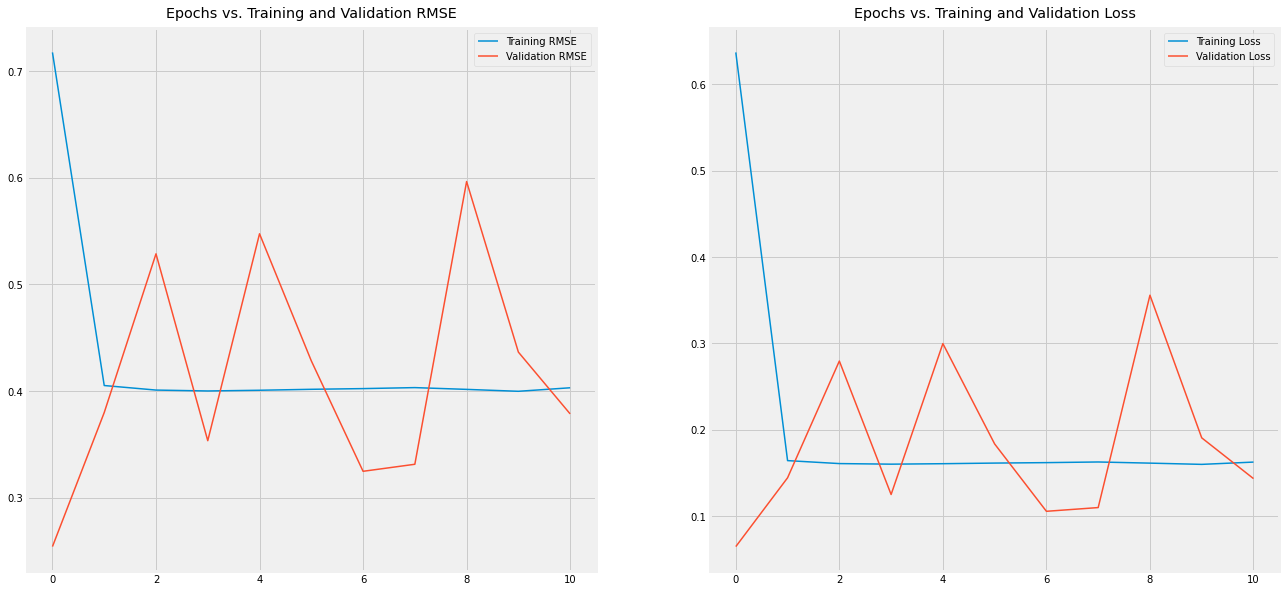

RMSE of the one-hour ahead electricity price, multivariate forecast: 7.59
R2 of the one-hour ahead electricity price, multivariate forecast: -2.264
MAE of the electricity price, multivariate forecast: 6.509.




Below is the graph that compares
the actual value with the predicted value:


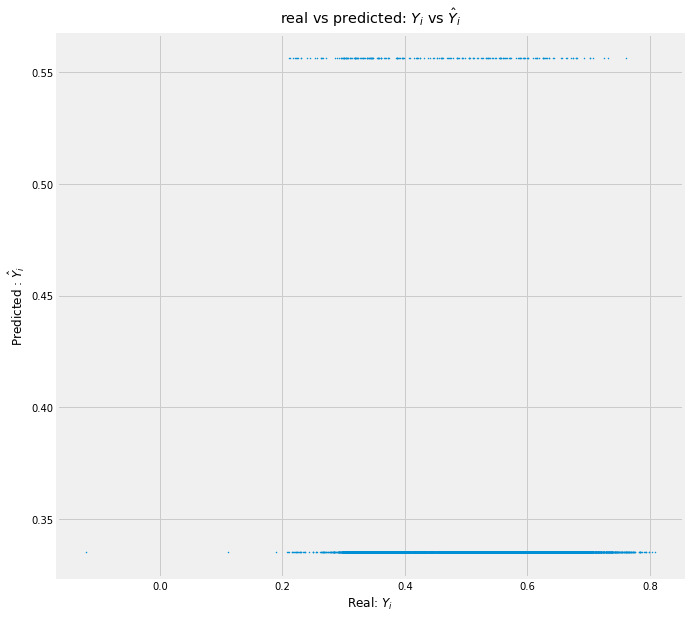

We will make predictions for 2 sets of values in the validation set:


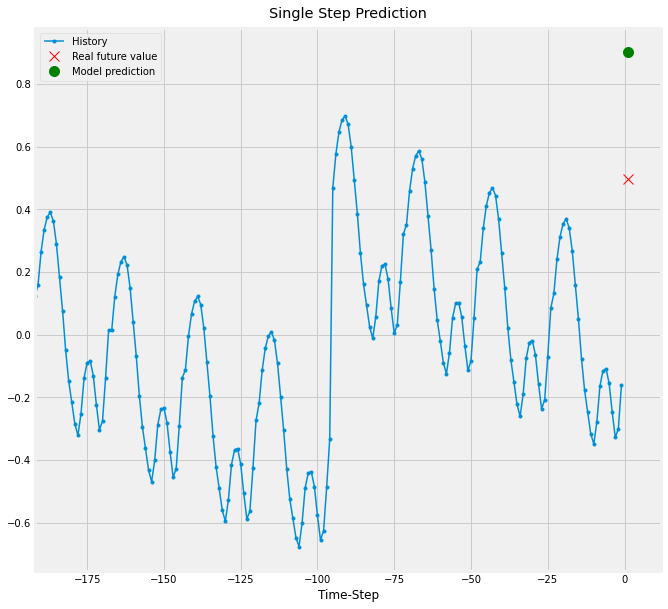

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 192, 150)          95400     
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 200)               5760200   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 5,855,801
Trainable params: 5,855,801
Non-trainable params: 0
_________________________________________________________________


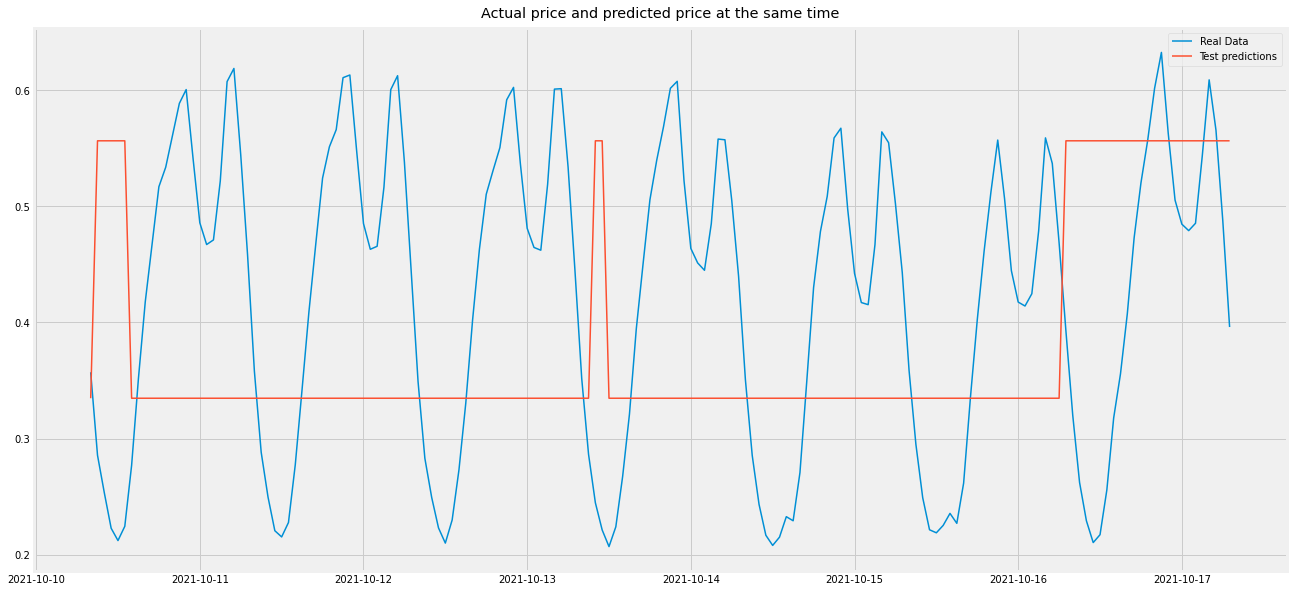

In [ ]:
#Cleaning possible variables
#===============================================================================
tf.keras.backend.clear_session()
#Cration of the model
#===============================================================================
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(150, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='sigmoid'),
    Dropout(0.1),
    Dense(1)
])



checkPoint_file = 'multivariate_lstm.h5'
opt = 6e-3
n_hours = 168


model_checkpoint, multivariate_lstm = model_settings(checkPoint_file,opt, multivariate_lstm)

#train the model with fit() keep the obkect 'history'
#'history', contains the values of losses and metrics in the training
history = multivariate_lstm.fit(train, epochs=100, verbose = 1,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])
plot_model_rmse_and_loss(history)

prediccion_T = test_predictions(checkPoint_file)

real_VS_predicted(y_test, prediccion_T)

validation_prediction(num,step,multivariate_lstm)

graphic_hours(n_hours)

multivariate_lstm.summary()


##RNN

In [ ]:
#Cleaning possible variables
#===============================================================================
tf.keras.backend.clear_session()
#Cration of the model
#===============================================================================
rnn_model = Sequential([
    tf.keras.layers.SimpleRNN(40,activation="relu",return_sequences=True, input_shape=input_shape),
    Dropout(0.15),
    tf.keras.layers.SimpleRNN(40,activation="relu",return_sequences=True),
    Dropout(0.15),
    tf.keras.layers.SimpleRNN(40,activation="relu",return_sequences=True),
    Dropout(0.15),
    Dense(1),
])


checkPoint_file = 'RNN.h5'
opt = 6e-3
n_hours = 168


model_checkpoint, rnn_model = model_settings(checkPoint_file,opt, rnn_model)

#train the model with fit() keep the obkect 'history'
#'history', contains the values of losses and metrics in the training
history = rnn_model.fit(train, epochs=100, verbose = 1,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

#Using the functions that we already prepared
#===============================================================================
plot_model_rmse_and_loss(history)

prediccion_T = test_predictions(checkPoint_file)

real_VS_predicted(y_test, prediccion_T)

validation_prediction(num,step,rnn_model)

graphic_hours(n_hours)

rnn_model.summary()

In [ ]:
df_final.tail(10)

In [ ]:
df_final2 = df_final

In [ ]:
steps = 13000
df_final2['consumptionInCeuta'] = df_final2['consumptionInCeuta'].shift(-24)
df_final2.drop(df_final2.tail(24).index,inplace=True)
data_train = df_final2[:-steps]
data_test  = df_final2[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['consumptionInCeuta'].plot(ax=ax, label='train')
data_test['consumptionInCeuta'].plot(ax=ax, label='test')
ax.legend();


In [ ]:

steps = 13000
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5,10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['consumptionInCeuta'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False)


##Random Forest

In [ ]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['consumptionInCeuta'])

predictions = forecaster.predict(steps=steps)

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['consumptionInCeuta'].plot(ax=ax, label='train')
data_test['consumptionInCeuta'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
real_VS_predicted(data_test['consumptionInCeuta'], predictions)

In [ ]:
# Test error
# ==============================================================================
error_rmse = sqrt(mean_squared_error(
                y_true = data_test['consumptionInCeuta'],
                y_pred = predictions
                ))

print(f"Test error (rmse): {error_rmse}")

In [ ]:
    rmse_mult_model = sqrt(mean_squared_error(data_test['consumptionInCeuta'],  predictions))
    print('RMSE of the one-hour ahead electricity price, multivariate forecast: {}' .format(round(rmse_mult_model, 3)))

    r2 = r2_score(data_test['consumptionInCeuta'], predictions)
    print('R2 of the one-hour ahead electricity price, multivariate forecast: {}' .format(round(r2, 3)))

    MAE = abs((data_test['consumptionInCeuta'] - predictions)).mean()
    print("MAE of the electricity price, multivariate forecast: {}.".format(round(MAE,3)))

In [ ]:
'''
steps = 13000
forecaster = ForecasterAutoreg(
                regressor = LinearRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5,10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['consumptionInCeuta'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )
'''

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 20
             )

forecaster.fit(y=data_train['consumptionInCeuta'])
predictions = forecaster.predict(steps=steps)

In [ ]:
# Test error
# ==============================================================================
error_rmse = sqrt(mean_squared_error(
                y_true = data_test['consumptionInCeuta'],
                y_pred = predictions
                ))

print(f"Test error (rmse): {error_rmse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['consumptionInCeuta'].plot(ax=ax, label='train')
data_test['consumptionInCeuta'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();